In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
%pylab inline
pylab.rcParams.update({'font.size': 12})
pylab.rcParams.update({'font.family': 'sans serif'})
pylab.rcParams.update({'mathtext.default':'regular'})
pylab.rcParams.update({'mathtext.fontset':'stixsans'})
pylab.rcParams.update({'axes.linewidth': 1.5})
pylab.rcParams.update({'xtick.direction':'in'})
pylab.rcParams.update({'xtick.major.size': 5})
pylab.rcParams.update({'xtick.major.width': 1.25 })
pylab.rcParams.update({'xtick.minor.size': 2.5})
pylab.rcParams.update({'xtick.minor.width': 1.25 })
pylab.rcParams.update({'ytick.direction':'in'})
pylab.rcParams.update({'ytick.major.size': 5})
pylab.rcParams.update({'ytick.major.width': 1.25 })
pylab.rcParams.update({'ytick.minor.size': 2.5})
pylab.rcParams.update({'ytick.minor.width': 1.25 })

import warnings
warnings.filterwarnings("ignore")

T_colors = ["lightskyblue", "violet", "forestgreen", "darkviolet", "thistle", "cadetblue", 
            "palegoldenrod", "darksalmon", "indigo"]

Populating the interactive namespace from numpy and matplotlib


In [2]:
class SimUnitConverter:
    
    def __init__(self):
        # conversion factors to get CGS units into Cholla units
        self._LENGTH_UNIT = 3.08567758e21 # kpc in cm
        self._MASS_UNIT = 1.98855e33 # solar mass in grams
        self._TIME_UNIT = 3.15569e10 # kyr in s
        self._DENSITY_UNIT = (self._MASS_UNIT/(self._LENGTH_UNIT**3))
        self._VELOCITY_UNIT = (self._LENGTH_UNIT/self._TIME_UNIT)
        self._PRESSURE_UNIT = (self._DENSITY_UNIT*self._VELOCITY_UNIT**2)

    def density(self, d_cgs):
        # convert g/cm^3 to M_sun/kpc^3
        return d_cgs / self._DENSITY_UNIT
    
    def mass(self, m_cgs):
        # convert g to M_sun
        return m_cgs / self._MASS_UNIT
    
    def time(self, t_cgs):
        # convert s to kyr
        return t_cgs / self._TIME_UNIT
    
    def length(self, l_cgs):
        # convert cm to kpc
        return l_cgs / self._LENGTH_UNIT
    
    def velocity(self, v_cgs):
        # convert cm/s to kpc/kyr
        return v_cgs / self._VELOCITY_UNIT

    def pressure(self, p_cgs):
        # convert g*cm^-1*s^-2 to M_sun*kpc^-1*kyr^-2
        return p_cgs / self._PRESSURE_UNIT

In [3]:
class AccretionIntegrator:
    MP = 1.6726219e-24 # proton mass in g
    # use this conversion just because it's easier to think about time in terms of years
    YR_IN_S = 3.154e7 # one year in s
    # solar abundances (percentage of total mass)
    # O, C, N, Si, Mg, Ne, Fe, S
    metals = np.array([0.0097, 0.0040, 0.00096, 0.00099, 0.00076, 0.00058, 0.0014, 0.00040]);
    metallicity = np.sum(metals)
        
    def __init__(self, T, n, dt, tmax):
        self.T = T
        self.n = n
        self.dt = dt # gets passed in in s
        self._d0_gas, self._d0_metal, self._d0_dust = self.calc_init_density()
        self.d_gas, self.d_metal, self.d_dust = self.calc_init_density()
        self.tau_g = self.calc_tau_g() # s
        self.type = "Accretion"

    def calc_tau_g(self):
        tau_g_ref = 0.2e9 * self.YR_IN_S # 0.2 Gyr in s
        d_ref = self.MP # 1 H atom per cubic centimer
        T_ref = 20.0; # 20 K
        tau_g = tau_g_ref * (d_ref/(self._d0_gas)) * (T_ref/self.T) ** (1/2); # s
    
        return tau_g
    
    def calc_init_density(self):
        d0_gas = self.MP * self.n # g/cm^3
        d0_metal = self.metallicity * d0_gas
        # assume 1% dust to gas fraction
        d0_dust = d0_gas / 100
        
        return d0_gas, d0_metal, d0_dust

    def calc_dd_dt(self):
        dd_dt = (1 - self.d_dust/self.d_metal)*(self.d_dust/self.tau_g) # g/cm^3/s
        
        return dd_dt
    
    def calc_d_dust(self):
        dd_dt = self.calc_dd_dt()
        d_dust_i = self.d_dust + self.dt * dd_dt
        
        return d_dust_i
    
    def update_densities(self):
        dd_dt = self.calc_dd_dt()
        self.d_dust += self.dt * dd_dt
        self.d_metal -= self.dt * dd_dt
    
    def get_info(self):
        print("Gas temperature: {:.1E} K".format(self.T))
        print("Gas initial density: {:.5E} g/cm^3".format(self._d0_gas))
        print("Growth timescale: {:.5E} yr".format(self.tau_g/self.YR_IN_S))
        print("Time-step: {:.1E} yr".format(self.dt/self.YR_IN_S))
        print("------------------------------------------")

In [14]:
def evolve_solutions(h, n, T_arr, tmax):
    YR_IN_S = 3.154e7
    h *= YR_IN_S
    tmax = tmax * YR_IN_S
    
    t_arr = np.arange(0, tmax, h)
    
    d_dust = np.zeros(shape=(len(T_arr), len(t_arr)))
    d_metal = np.zeros(shape=(len(T_arr), len(t_arr)))

    integrators = []
    
    taus = []
    
    def time_refine(integrator):
        """Refine time-step if dd is changing too rapidly."""
        d_dust_i = integrator.calc_d_dust()
        dd_dt = integrator.calc_dd_dt()
        dt = integrator.dt
        dd = dd_dt * dt
        while dd/d_dust_i > 0.01:
            dt_sub = 0.01 * d_dust_i / dd_dt

            integrator.d_dust += dt_sub * dd_dt
            integrator.d_metal -= dt_sub * dd_dt
            integrator.dt -= dt_sub
            dt = integrator.dt
            dd_dt = integrator.calc_dd_dt()
            dd = dt * dd_dt

    for j, T in enumerate(T_arr):
        integrator = AccretionIntegrator(T, n, h, tmax)
        integrator.get_info()
        # set initial densities
        d_dust[j][0] = integrator._d0_dust
        d_metal[j][0] = integrator._d0_metal
        taus.append(integrator.tau_g) # s
        integrators.append(integrator)

        for i, t_i in enumerate(t_arr):
            if (i+1) < len(t_arr):
                d_dust_i = integrator.calc_d_dust()
                dd_dt = integrator.calc_dd_dt()
                dd = integrator.dt * dd_dt
                
                # if rate of dust growth is changing too rapidly
                if dd/d_dust_i > 0.01:
                    # shorten time-step
                    time_refine(integrator)
                    integrator.dt = h
                    d_dust[j][i+1] = integrator.d_dust
                    d_metal[j][i+1] = integrator.d_metal
                    continue

                integrator.update_densities()
                d_dust[j][i+1] = integrator.d_dust
                d_metal[j][i+1] = integrator.d_metal

    return d_dust, d_metal, taus, integrators

In [5]:
T_arr = [10, 100, 1000, 1e4, 1e5, 1e6, 1e7, 1e8]

h = 100
n = 1
tmax = 1e8

dd, dm, tau_gs, acc_integrator = evolve_solutions(h, n, T_arr, tmax)

Gas temperature: 1.0E+01 K
Gas initial density: 1.67262E-24 g/cm^3
Growth timescale: 2.82843E+08 yr
Time-step: 1.0E+02 yr
------------------------------------------
Gas temperature: 1.0E+02 K
Gas initial density: 1.67262E-24 g/cm^3
Growth timescale: 8.94427E+07 yr
Time-step: 1.0E+02 yr
------------------------------------------
Gas temperature: 1.0E+03 K
Gas initial density: 1.67262E-24 g/cm^3
Growth timescale: 2.82843E+07 yr
Time-step: 1.0E+02 yr
------------------------------------------
Gas temperature: 1.0E+04 K
Gas initial density: 1.67262E-24 g/cm^3
Growth timescale: 8.94427E+06 yr
Time-step: 1.0E+02 yr
------------------------------------------
Gas temperature: 1.0E+05 K
Gas initial density: 1.67262E-24 g/cm^3
Growth timescale: 2.82843E+06 yr
Time-step: 1.0E+02 yr
------------------------------------------
Gas temperature: 1.0E+06 K
Gas initial density: 1.67262E-24 g/cm^3
Growth timescale: 8.94427E+05 yr
Time-step: 1.0E+02 yr
------------------------------------------
Gas temper

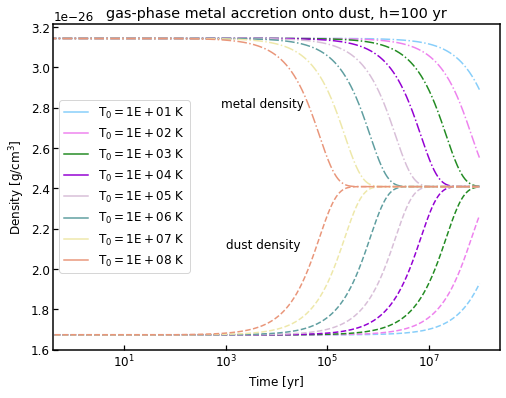

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8,6))
for j, T in enumerate(T_arr):
    ax.semilogx(np.arange(0, tmax, h), dd[j], linestyle="--", color=T_colors[j])
    ax.semilogx(np.arange(0, tmax, h), dm[j], linestyle="-.", color=T_colors[j])
    ax.semilogx(np.ones(5), acc_integrator[j].d_dust * np.ones(5), linestyle="-", color=T_colors[j], label=f"$T_0={T:.0E}~K$")
ax.annotate("dust density", (0.99999999e3, 2.1e-26))
ax.annotate("metal density", (0.8e3, 2.8e-26))
ax.set_xlabel("Time$~[yr]$")
ax.set_ylabel(r"Density$~[g/cm^3]$")
ax.legend()
ax.set_title(f"gas-phase metal accretion onto dust, h={h} yr")
plt.savefig("/Users/helenarichie/GitHub/helenarichie.github.io/assets/img/posts/accretion_numerical.png", facecolor="white")

Text(0, 0.5, '$\\tau_g~[yr]$')

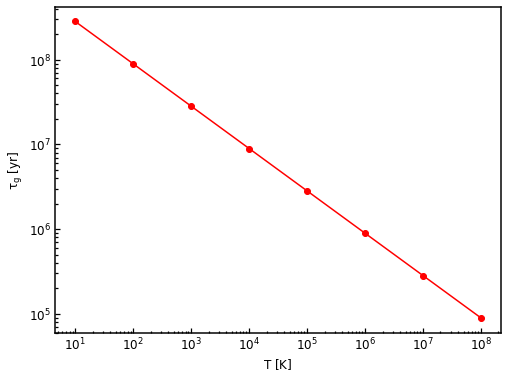

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8,6))
tau_g_yr = []
for j, acc_int in enumerate(acc_integrator):
    tau_g_yr.append(acc_int.tau_g/acc_int.YR_IN_S)
ax.loglog(T_arr, tau_g_yr, "-o", c="r")
ax.set_xlabel(r"$T~[K]$")
ax.set_ylabel(r"$\tau_g~[yr]$")

In [12]:
T_arr = [1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8]

h = 100
n = 1e-2
tmax = 1e8

dd, dm, taus, integrator = evolve_solutions(h, n, T_arr, tmax)

Gas temperature: 1.0E+01 K
Gas initial density: 1.67262E-26 g/cm^3
Growth timescale: 2.82843E+10 yr
Time-step: 1.0E+02 yr
------------------------------------------
Gas temperature: 1.0E+02 K
Gas initial density: 1.67262E-26 g/cm^3
Growth timescale: 8.94427E+09 yr
Time-step: 1.0E+02 yr
------------------------------------------
Gas temperature: 1.0E+03 K
Gas initial density: 1.67262E-26 g/cm^3
Growth timescale: 2.82843E+09 yr
Time-step: 1.0E+02 yr
------------------------------------------
Gas temperature: 1.0E+04 K
Gas initial density: 1.67262E-26 g/cm^3
Growth timescale: 8.94427E+08 yr
Time-step: 1.0E+02 yr
------------------------------------------
Gas temperature: 1.0E+05 K
Gas initial density: 1.67262E-26 g/cm^3
Growth timescale: 2.82843E+08 yr
Time-step: 1.0E+02 yr
------------------------------------------
Gas temperature: 1.0E+06 K
Gas initial density: 1.67262E-26 g/cm^3
Growth timescale: 8.94427E+07 yr
Time-step: 1.0E+02 yr
------------------------------------------
Gas temper

Text(0.5, 1.0, 'gas-phase metal accretion onto dust')

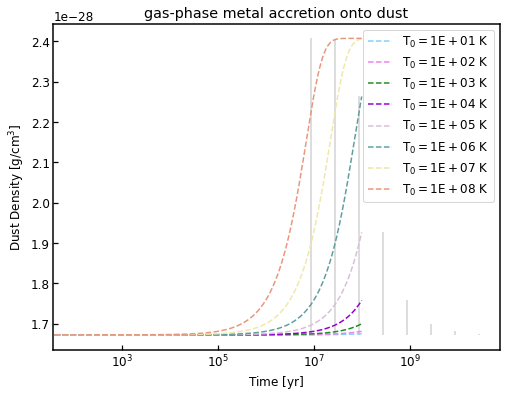

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8,6))
for j, T in enumerate(T_arr):
    ax.semilogx(np.arange(0, tmax, h), dd[j], linestyle="--", color=T_colors[j], label=f"$T_0={T:.0E}~K$")
    ax.vlines(integrator[j].tau_g/integrator[j].YR_IN_S, ymin=np.amin(dd[j]), ymax=np.amax(dd[j]), color="lightgrey")
ax.set_xlabel("Time$~[yr]$")
ax.set_ylabel(r"Dust Density$~[g/cm^3]$")
ax.legend()
ax.set_title(f"gas-phase metal accretion onto dust")